In [1]:
import sys
import os
sys.path.append("../../libraries/pvae/")
from pvae.manifolds.poincareball import PoincareBall
from pvae.manifolds.euclidean import Euclidean
from pvae.models.architectures import EncWrapped, DecWrapped
from pvae.distributions.wrapped_normal import WrappedNormal
from pvae.distributions.riemannian_normal import RiemannianNormal
from pvae.ops.manifold_layers import GeodesicLayer
from pvae.objectives import vae_objective
from torch.distributions.normal import Normal
sys.path.append("../../libraries/")
from HypHC.optim.radam import RAdam
from HypHC.utils.poincare import project
from HypHC.utils.visualization import plot_tree_from_leaves
from HypHC.utils.linkage import nn_merge_uf_fast_np, sl_from_embeddings
from HypHC.utils.metrics import dasgupta_cost
sys.path.append("../hyperLAI")
import math
import torch
from torch import nn
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import scipy.cluster.hierarchy as sch
from models.hyperbolic_hc_loss import HyperbolicHCLoss
from models.encoder_decoder_architectures import *
from models.vae_model import vae_model
from torch.utils.data import SubsetRandomSampler, DataLoader, Subset
from torch.optim import Adam
from utils.sim_funcs import sim_func_dict
from utils.model_utils import *
from features.hyperLAIdataset import HyperLoader
from models.fc_model import fc_model

enc_dec_dict = {"fc_wrapped_encoder": fc_wrapped_encoder, "fc_wrapped_decoder": fc_wrapped_decoder, "fc_geodesic_decoder": fc_geodesic_decoder} 
manifold_dict = {"PoincareBall": PoincareBall, "Euclidean": Euclidean}
distribution_dict = {"WrappedNormal": WrappedNormal, "Normal": Normal, "RiemannianNormal": RiemannianNormal}


In [2]:
model_dir = "/scratch/users/patelas/hyperLAI/models/vae_models/full_pop_models/500000_threelayers_tempnegsix/"
args = read_config(model_dir + "vae_config.json")
indices = np.load(args["index_loc"] + "train_indices.npy")
train_dataset = HyperLoader(args["data_dir"], indices, args["restrict_labels"], args["chromosome"])
# train_loader = DataLoader(eval_dataset, batch_size=64)


In [3]:
def make_pairwise_similarities(data, sim_func):
    '''
    Creates a similarity matrix from the SNP data using the specified similarity function
    This is a numpy version of the function used in training
    '''
    sim_matrix = np.zeros((data.shape[0], data.shape[0]))
    #Fill in matrix
    for ind in range(data.shape[0]):
        for ind2 in range(data.shape[0]):
            sim_matrix[ind][ind2] = sim_func(data[ind], data[ind2])
    return sim_matrix


In [4]:
np.random.seed(0)
shortened_inds = np.random.choice(len(train_dataset.snps), 2000, replace=False)

In [5]:
train_data_shortened = train_dataset.snps[shortened_inds]

In [6]:
sim_mat = make_pairwise_similarities(train_data_shortened, lambda x,y: (np.sum(x==y)) / len(x))

In [29]:
print(np.mean(sim_mat))

0.5021306755160001


In [30]:
print(np.min(sim_mat), np.max(sim_mat))

0.451166 1.0


In [31]:
print(np.std(sim_mat), np.var(sim_mat))

0.03195104389255873 0.0010208692058242144


In [33]:
np.max(sim_mat) - np.min(sim_mat)

0.548834

In [7]:
sim_mat

array([[1.      , 0.512098, 0.48226 , ..., 0.52011 , 0.515452, 0.519826],
       [0.512098, 1.      , 0.489846, ..., 0.503952, 0.518422, 0.506728],
       [0.48226 , 0.489846, 1.      , ..., 0.49663 , 0.476624, 0.483178],
       ...,
       [0.52011 , 0.503952, 0.49663 , ..., 1.      , 0.51145 , 0.533372],
       [0.515452, 0.518422, 0.476624, ..., 0.51145 , 1.      , 0.522574],
       [0.519826, 0.506728, 0.483178, ..., 0.533372, 0.522574, 1.      ]])

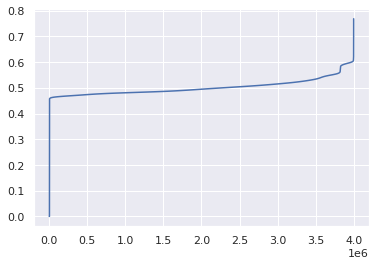

In [40]:
plt.plot(np.sort(np.where(sim_mat == 1, 0, sim_mat).flatten()))
plt.show()

In [72]:
res_pop_labels = train_dataset.pop_labels[shortened_inds]
res_suppop_labels = train_dataset.suppop_labels[shortened_inds]
res_suppop_labels[891] = 0

In [73]:
pop_sim_mat = np.zeros([len(res_pop_labels), len(res_pop_labels)])
for ind, label in enumerate(res_pop_labels):
    for ind2, label2 in enumerate(res_pop_labels):
        if ind != ind2 and label == label2:
            pop_sim_mat[ind][ind2] = 1
        elif ind == ind2:
            pop_sim_mat[ind][ind2] = 2

In [74]:
suppop_sim_mat = np.zeros([len(res_suppop_labels), len(res_suppop_labels)])
for ind, label in enumerate(res_suppop_labels):
    for ind2, label2 in enumerate(res_suppop_labels):
        if ind != ind2 and label == label2:
            suppop_sim_mat[ind][ind2] = 1
        elif ind == ind2:
            suppop_sim_mat[ind][ind2] = 2

In [84]:
sim_same_pop, sim_diff_pop = sim_mat[np.where(pop_sim_mat * sim_mat == sim_mat)], sim_mat[np.where(pop_sim_mat * sim_mat == 0)]
sim_same_suppop, sim_diff_suppop = sim_mat[np.where(suppop_sim_mat * sim_mat == sim_mat)], sim_mat[np.where(suppop_sim_mat * sim_mat == 0)]
same_sup_diff_pop = sim_mat[np.where((suppop_sim_mat == 1) & (pop_sim_mat == 0))]




In [80]:
np.mean(sim_same_pop), np.std(sim_same_pop), np.min(sim_same_pop), np.max(sim_same_pop)

(0.5532499474274661, 0.03014824531511398, 0.494906, 0.768654)

In [81]:
np.mean(sim_diff_pop), np.std(sim_diff_pop), np.min(sim_diff_pop), np.max(sim_diff_pop)

(0.5005178086324658, 0.028724458593363675, 0.451166, 0.665782)

In [82]:
np.mean(sim_same_suppop), np.std(sim_same_suppop), np.min(sim_same_suppop), np.max(sim_same_suppop)

(0.5452328820153505, 0.02880265392833213, 0.482448, 0.768654)

In [83]:
np.mean(sim_diff_suppop), np.std(sim_diff_suppop), np.min(sim_diff_suppop), np.max(sim_diff_suppop)

(0.4899749218754988, 0.016061776666808088, 0.451166, 0.564242)

In [86]:
np.mean(same_sup_diff_pop), np.std(same_sup_diff_pop), np.min(same_sup_diff_pop), np.max(same_sup_diff_pop)

(0.5441393593186891, 0.028439594209589282, 0.482448, 0.665782)

In [59]:
np.where((suppop_sim_mat == 0) & (pop_sim_mat == 1) )

(array([ 867,  891,  891, 1226]), array([ 891,  867, 1226,  891]))

In [31]:
len(np.unique(res_pop_labels))

119

In [62]:
res_pop_labels[891], res_suppop_labels[891], res_pop_labels[867], res_suppop_labels[867], res_pop_labels[1226], res_suppop_labels[1226]





(110, 6, 110, 0, 110, 0)

In [50]:
for ind, lab in enumerate(res_pop_labels):
    print(ind, lab)

0 32
1 15
2 12
3 12
4 25
5 18
6 2
7 77
8 14
9 24
10 25
11 8
12 4
13 7
14 6
15 18
16 20
17 4
18 131
19 11
20 43
21 15
22 65
23 76
24 2
25 20
26 33
27 24
28 0
29 50
30 21
31 12
32 0
33 18
34 16
35 25
36 12
37 2
38 75
39 0
40 29
41 9
42 25
43 2
44 0
45 9
46 4
47 19
48 40
49 30
50 71
51 49
52 18
53 40
54 9
55 43
56 18
57 30
58 25
59 16
60 25
61 24
62 4
63 9
64 36
65 8
66 2
67 133
68 9
69 13
70 0
71 51
72 49
73 15
74 31
75 21
76 31
77 11
78 49
79 100
80 1
81 62
82 11
83 14
84 76
85 0
86 73
87 45
88 50
89 18
90 26
91 0
92 21
93 4
94 42
95 9
96 8
97 144
98 12
99 19
100 67
101 20
102 0
103 18
104 55
105 49
106 6
107 25
108 19
109 18
110 15
111 14
112 44
113 54
114 52
115 8
116 11
117 13
118 49
119 34
120 4
121 45
122 9
123 14
124 16
125 24
126 20
127 19
128 1
129 14
130 13
131 2
132 20
133 55
134 9
135 42
136 0
137 16
138 21
139 25
140 8
141 11
142 2
143 6
144 45
145 37
146 24
147 2
148 31
149 19
150 16
151 20
152 20
153 6
154 15
155 19
156 11
157 4
158 18
159 11
160 34
161 6
162 56
163 14
164

In [87]:
pca_test = PCA().fit_transform(train_data_shortened)

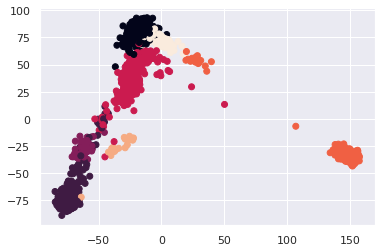

In [93]:
plt.scatter(pca_test[:,0], pca_test[:,1], c=res_suppop_labels)
plt.show()